## Introduction

This notebook provides a step-by-step guide on how to merge two congeneric ligands with a shared substructure into a hybrid topology. It also covers the preparation of all necessary files required for performing relative binding free energy (RBFE) calculations using GROMACS.

To begin, we will import the required libraries. These libraries handle molecular visualization, topology preparation (rdkit), and data analysis (alchemlyb).

In [2]:
import re
import shutil
import os

import alchemlyb
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.preprocessing.subsampling import decorrelate_u_nk
from alchemlyb.estimators import MBAR
from alchemlyb.postprocessors.units import to_kcalmol, to_kJmol
from alchemlyb.visualisation import plot_convergence
from alchemlyb.convergence import forward_backward_convergence

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdMolAlign import AlignMol

import py3Dmol

# IPython utilities for displaying molecules and formatting output
from rdkit.Chem.Draw import IPythonConsole
Draw.rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.setHighlightColour((1.0, 0.75, 0.75))

In this example, we will use the Mycobacterium tuberculosis KasA protein (PDB ID: 6P9L) in complex with two ligands: the co-crystallized ligand (ligand A) and a congeneric ligand (ligand B). This example demonstrates how to merge these ligands into a hybrid topology and calculate the relative binding free energy (RBFE) between them. The ligands, along with the hybrid structure, are displayed below, with the common substructure highlighted in red.

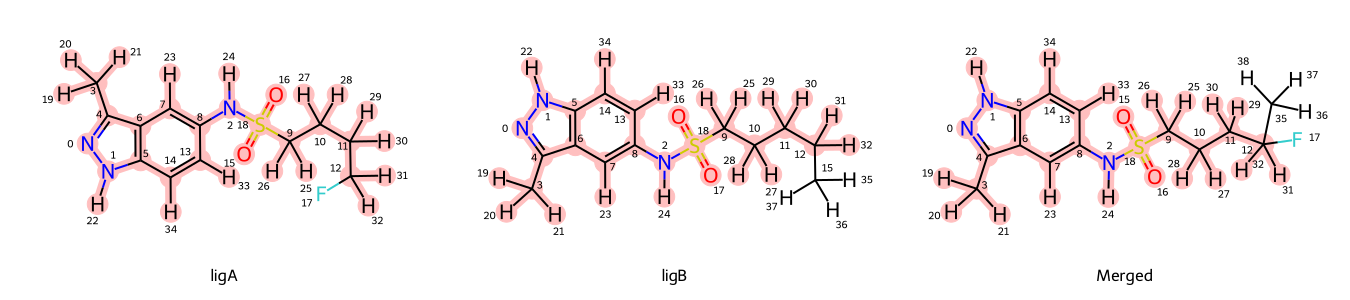

In [3]:
# Load ligand structures from MOL2 files (keeping hydrogen atoms)
ligA = Chem.MolFromMol2File('input/ligA.mol2', removeHs=False)
ligB = Chem.MolFromMol2File('input/ligB.mol2', removeHs=False)

# Generate 2D coordinates for both ligands for visualization
AllChem.Compute2DCoords(ligA)
AllChem.Compute2DCoords(ligB)

# Identify the Maximum Common Substructure (MCS) between ligA and ligB
mcs = Chem.MolFromSmarts(FindMCS([ligA, ligB]).smartsString)

# Get atom indices of the common substructure in both ligands
mcs_atoms_A = ligA.GetSubstructMatch(mcs)
mcs_atoms_B = ligB.GetSubstructMatch(mcs)

# Identify unique atoms in both ligands that are not part of the common substructure
unique_atoms_A = [i for i in range(ligA.GetNumAtoms()) if i not in mcs_atoms_A]
unique_atoms_B = [i for i in range(ligB.GetNumAtoms()) if i not in mcs_atoms_B]

# Create mappings between atom indices of ligA and ligB
A_to_B = dict(zip(mcs_atoms_A, mcs_atoms_B))
B_to_A = dict(zip(mcs_atoms_B, mcs_atoms_A))

# Map atoms in ligB to the new hybrid molecule, reindexing unique atoms from ligB
B_to_merged = B_to_A | dict(
    zip(unique_atoms_B, range(ligA.GetNumAtoms(), ligA.GetNumAtoms() + len(unique_atoms_B)))
)

# Reindex atom indices in 1-based format for merged molecule
B_to_merged_reindexed = {i + 1: j + 1 for i, j in B_to_merged.items()}

# Create a new editable molecule starting with ligA as the base
rdmol_merged = Chem.RWMol(ligA)

# Add unique atoms from ligB to the merged molecule
new_bonds = {}
for i in unique_atoms_B:
    atom = ligB.GetAtomWithIdx(i)
    rdmol_merged.AddAtom(atom)
    # Record bonds involving the unique atom for later addition
    for bond in atom.GetBonds():
        new_bonds[(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())] = bond.GetBondType()

# Reindex the bonds to reflect the merged molecule’s atom indices
new_bonds_reindexed = {
    (B_to_merged[i], B_to_merged[j]): bond_type
    for (i, j), bond_type in new_bonds.items()
}

# Add the bonds to the merged molecule
for (i, j), bond_type in new_bonds_reindexed.items():
    rdmol_merged.AddBond(i, j, bond_type)

# Finalize the merged molecule and compute 2D coordinates for display
rdmol_merged = rdmol_merged.GetMol()
AllChem.Compute2DCoords(rdmol_merged)

# Display the ligands and the merged structure, highlighting the MCS in red
Draw.MolsToGridImage(
    [ligA, ligB, rdmol_merged],
    molsPerRow=3,
    subImgSize=(450, 300),
    legends=['ligA', 'ligB', 'Merged'],
    highlightAtomLists=[mcs_atoms_A, mcs_atoms_B, mcs_atoms_A]
)

## Hybrid Topology Preparation

As illustrated in the structures above, the only difference between the ligands is the group attached to atom 12. In the hybrid topology, referred to as `merged`, both the fluoride and methyl groups are attached to this atom. For the relative binding free energy (RBFE) calculation, we will use the alchemical approach, where one ligand is gradually transformed into the other. Specifically, the fluoride group will be transformed into a methyl group.

In state A, the ligand corresponds to ligand A, with dummy atoms representing the methyl group from ligand B. In state B, the ligand is ligand B, with dummy atoms representing the fluoride group from ligand A. In the merged topology, these dummy atoms are replaced by the actual atoms from both ligands.

To perform this calculation in GROMACS, we need to prepare the following files:

- `complex.top`: The topology file for the protein-ligand complex, which includes generating the merged ligand topology file, `merged.itp`.
- `complex.gro`: The coordinate file for the complex, which includes the merged ligand coordinates, `merged.gro`.

For this setup, we will use the **GAFF2** force field parameters for the ligands, the **AMBER99SB-ILDN** force field for the protein, and the TIP3P water model. The ligands will be parameterized using the `acpype` tool. You can also use Python’s `os` or `subprocess` modules if you want more control over the execution of these commands, but we'll use `!` throughout this notebook for simplicity.

The first step is to obtain the force field parameters for the ligands:

In [4]:
# Create output directories for storing the processed ligand files
! mkdir -p output/data

# Generate topology files for ligA using acpype with GAFF2 parameters
! acpype -i input/ligA.mol2 -b ligA -c bcc -a gaff2 -o gmx -w

# Move the generated topology file for ligA to the output directory and clean up intermediate files
! mv ligA.acpype/ligA_GMX.itp output/data/ligA.itp
! rm -r ligA.acpype

# Same as above, but for ligB
! acpype -i input/ligB.mol2 -b ligB -c bcc -a gaff2 -o gmx -w
! mv ligB.acpype/ligB_GMX.itp output/data/ligB.itp
! rm -r ligB.acpype

Next, we will read and parse the topology files of ligand A and ligand B. The goal is to generate a merged topology file that incorporates both ligands into a single hybrid structure:

In [5]:
def extract_sections(itp_path):
    """
    Extracts relevant sections (atomtypes, atoms, bonds, etc.) from a given .itp file.

    Parameters:
    - itp_path: Path to the .itp file

    Returns:
    - sections: A dictionary containing the extracted sections
    """
    sections = {
        "atomtypes": [],
        "atoms": [],
        "bonds": [],
        "pairs": [],
        "angles": [],
        "dihedrals": []
    }

    section_pattern = re.compile(r'\[\s*(\w+)\s*\]')  # Pattern to match section headers (e.g., [ atoms ])
    current_section = None  # Keeps track of the current section being parsed

    with open(itp_path, 'r') as file:
        for line in file:
            # Check if the line matches a section header
            match = section_pattern.match(line)
            if match:
                section_name = match.group(1).lower()
                # Set the current section if it matches one of the sections of interest
                current_section = section_name if section_name in sections else None
            elif current_section and line.strip() and not line.startswith(";"):
                # Add non-comment, non-empty lines to the current section
                sections[current_section].append(line.split(';')[0].strip())

    return sections

In [6]:
# Extract sections from both files
itp_path_A = 'output/data/ligA.itp'
itp_path_B = 'output/data/ligB.itp'
sections_A = extract_sections(itp_path_A)
sections_B = extract_sections(itp_path_B)

Next, we will extract the atom types and parameters for both ligands and introduce dummy atoms. These dummy atoms will allow us to combine the ligands into a merged topology file.

In [7]:
def process_atom(nr, typeA, resnr, res, atom, cgnr, chargeA, massA, typeB='', chargeB='', massB=''):
    """Helper function to process atoms and add them to the merged list."""
    resnr = '1'
    res = 'LIG'  # Use 'LIG' as residue name for merged ligand
    return [nr, typeA, resnr, res, atom, cgnr, chargeA, massA, typeB, chargeB, massB]

In [8]:
# Combine and deduplicate atomtypes from both ligands
atomtypes_A = sections_A['atomtypes']
atomtypes_B = sections_B['atomtypes']

atomtypes_merged = {
    name: (sigma, epsilon)
    for atomtype in set(atomtypes_A + atomtypes_B)
    for name, _, _, _, _, sigma, epsilon in [atomtype.split()]
}

# List to store merged atoms
atoms_merged = []

# Process the atoms unique to ligand A
for i in unique_atoms_A:
    atomA = sections_A['atoms'][i]
    nr, typeA, resnr, res, atom, cgnr, chargeA, massA = atomA.split()
    typeB = f'dum_{typeA}'  # Use dummy atom type for ligand B
    if typeB not in atomtypes_merged:
        atomtypes_merged[typeB] = ('0.000000000', '0.000000000')  # Add dummy atomtype if not present
    atoms_merged.append(process_atom(nr, typeA, resnr, res, atom, cgnr, chargeA, massA, typeB, '0.000000', massA))

# Process atoms common to both ligands (common substructure)
for i in mcs_atoms_A:
    atomA = sections_A['atoms'][i]
    atomB = sections_B['atoms'][A_to_B[i]]
    nr, typeA, resnr, res, atom, cgnr, chargeA, massA = atomA.split()
    _, typeB, _, _, _, _, chargeB, massB = atomB.split()
    
    # Handle atoms with different charges between ligands A and B
    if chargeA != chargeB:
        atoms_merged.append(process_atom(nr, typeA, resnr, res, atom, cgnr, chargeA, massA, typeB, chargeB, massB))
    else:
        atoms_merged.append(process_atom(nr, typeA, resnr, res, atom, cgnr, chargeA, massA))

# Process the atoms unique to ligand B
for i in unique_atoms_B:
    atomB = sections_B['atoms'][i]
    nr, typeB, resnr, res, atom, cgnr, chargeB, massB = atomB.split()
    nr = str(len(atoms_merged) + 1)  # Reindex the atom for the merged topology
    cgnr = str(len(atoms_merged) + 1)  # Use the new index for the charge group
    atom = 'D' + atom  # Prefix the atom name with 'D' to indicate dummy status
    typeA = f'dum_{typeB}'  # Dummy atom type for ligand A
    if typeA not in atomtypes_merged:
        atomtypes_merged[typeA] = ('0.000000000', '0.000000000')  # Add dummy atomtype if not present
    atoms_merged.append(process_atom(nr, typeA, resnr, res, atom, cgnr, '0.000000', massB, typeB, chargeB, massB))

# Sort the merged atoms by their index
atoms_merged = sorted(atoms_merged, key=lambda x: int(x[0]))

Next, we will apply the same process to the bonds, pairs, angles, and dihedrals to combine and deduplicate these sections from both ligands:

In [9]:
# Process the bonds of ligand A
bonds_A = {
    (int(i), int(j)): (b0, kb)  # (i, j) are atom indices, b0 is bond length, kb is force constant
    for line in sections_A['bonds']
    for i, j, _, b0, kb in [line.split()]
}

# Process the bonds of ligand B with reindexed atom indices for the merged molecule
bonds_B = {
    (B_to_merged_reindexed[int(i)], B_to_merged_reindexed[int(j)]): (b0, kb)
    for line in sections_B['bonds']
    for i, j, _, b0, kb in [line.split()]
}

# Combine bonds from both ligands, deduplicating any common bonds
bonds_merged = bonds_A | {bond: bonds_B[bond] for bond in bonds_B if bond not in bonds_A}

In [10]:
# Process the pairs of ligand A
pairs_A = [
    (int(i), int(j))  # (i, j) are atom indices for the interaction pairs
    for line in sections_A['pairs']
    for i, j, _ in [line.split()]
]

# Process the pairs of ligand B with reindexed atom indices for the merged molecule
pairs_B = [
    (B_to_merged_reindexed[int(i)], B_to_merged_reindexed[int(j)])
    for line in sections_B['pairs']
    for i, j, _ in [line.split()]
]

# Combine and deduplicate pairs from both ligands
pairs_merged = pairs_A + sorted(list(set(pairs_B) - set(pairs_A)))  # Add unique pairs from ligand B to pairs_A

In [11]:
# Process the angles of ligand A
angles_A = {
    (int(i), int(j), int(ak)): (th0, cth)  # (i, j, ak) are atom indices, th0 is the angle, cth is the force constant
    for line in sections_A['angles']
    for i, j, ak, _, th0, cth in [line.split()]
}

# Process the angles of ligand B with reindexed atom indices for the merged molecule
angles_B = {
    (B_to_merged_reindexed[int(i)], B_to_merged_reindexed[int(j)], B_to_merged_reindexed[int(ak)]): (th0, cth)
    for line in sections_B['angles']
    for i, j, ak, _, th0, cth in [line.split()]
}

# Combine and deduplicate angles from both ligands
angles_merged = angles_A | {angle: angles_B[angle] for angle in angles_B if angle not in angles_A}

In [12]:
# Process the dihedrals of ligand A
dihedrals_A = {
    (int(i), int(j), int(k), int(l)): (funct, phi0, kphi, n)  # (i, j, k, l) are atom indices, phi0 is the phase angle
    for line in sections_A['dihedrals']                      # kphi is the force constant, n is multiplicity
    for i, j, k, l, funct, phi0, kphi, n in [line.split()]
}

# Process the dihedrals of ligand B with reindexed atom indices for the merged molecule
dihedrals_B = {
    (B_to_merged_reindexed[int(i)], B_to_merged_reindexed[int(j)], B_to_merged_reindexed[int(k)],
     B_to_merged_reindexed[int(l)]): (funct, phi0, kphi, n)
    for line in sections_B['dihedrals']
    for i, j, k, l, funct, phi0, kphi, n in [line.split()]
}

# Combine and deduplicate dihedrals from both ligands
dihedrals_merged = dihedrals_A | {dihedral: dihedrals_B[dihedral] for dihedral in dihedrals_B if dihedral not in dihedrals_A}

Next, we will format the strings containing the structural information for the ligands:

In [13]:
def format_atomtype_entry(name, sigma, epsilon):
    """
    Formats a single atomtype entry for the force field file."""
    return f"  {name:<7}  0.00000  0.00000    A    {sigma:>12}  {epsilon:>12}\n"

def format_atom_entry(nr, type, resnr, residue, atom, cgnr, charge, mass, typeB='', chargeB='', massB=''):
    """Formats a single atom entry for the merged .itp file."""
    return (
        f"  {nr:<4}  "
        f"{type:<7} "
        f"{resnr:>3}      "
        f"{residue:>3}     "
        f"{atom:<5}  "
        f"{cgnr:<3}   "
        f"{charge:>9}   "
        f"{mass:>9}    "
        f"{typeB:<7} "
        f"{chargeB:>9}   "
        f"{massB:>9}"
    )

def format_bond_entry(i, j, b0, kb):
    """Formats a single bond entry for the merged .itp file."""
    return f"  {i:<5}  {j:<5}   1   {b0:>12}   {kb:>12}"

def format_pair_entry(i, j):
    """Formats a single pair entry for the merged .itp file."""
    return f"  {i:<5}  {j:<5}   1"

def format_angle_entry(ai, aj, ak, th0, cth):
    """Formats a single angle entry for the merged .itp file."""
    return f"  {ai:<5}  {aj:<5}  {ak:<5}   1   {th0:>12}   {cth:>12}"

def format_dihedral_entry(ai, aj, ak, al, funct, phi0, kphi, n):
    """Formats a single dihedral entry for the merged .itp file."""
    return f"  {ai:<5}  {aj:<5}  {ak:<5}  {al:<5}   {funct}  {phi0:>10}  {kphi:>10}    {n:>2}"

In [14]:
sections_merged = {
    "moleculetype": [],
    "atoms": [],
    "bonds": [],
    "pairs": [],
    "angles": [],
    "dihedrals": []
}

# Add moleculetype to the merged .itp file
sections_merged['moleculetype'].append('; name       nrexcl')
sections_merged['moleculetype'].append('  Ligand       3')

atomtypes_formatted = [
    format_atomtype_entry(name, sigma, epsilon)
    for name, (sigma, epsilon) in atomtypes_merged.items()
]

# Add formatted atoms to the merged .itp file
sections_merged['atoms'].append(
    '; nr   type     resnr  residue  atom   cgnr     charge       mass     typeB      chargeB      massB'
)
atoms_formatted = [format_atom_entry(*atom_entry) for atom_entry in atoms_merged]
sections_merged['atoms'] += atoms_formatted

# Add formatted bonds to the merged .itp file
sections_merged['bonds'].append('; ai     aj    funct       b0             kb')
bonds_formatted = [format_bond_entry(i, j, b0, kb) for (i, j), (b0, kb) in bonds_merged.items()]
sections_merged['bonds'] += bonds_formatted

# Add formatted pairs to the merged .itp file
sections_merged['pairs'].append('; ai     aj    funct')
pairs_formatted = [format_pair_entry(i, j) for i, j in pairs_merged]
sections_merged['pairs'] += pairs_formatted

# Add formatted angles to the merged .itp file
sections_merged['angles'].append('; ai     aj    ak     funct       th0            cth')
angles_formatted = [format_angle_entry(ai, aj, ak, th0, cth) for (ai, aj, ak), (th0, cth) in angles_merged.items()]
sections_merged['angles'] += angles_formatted

# Add formatted dihedrals to the merged .itp file
sections_merged['dihedrals'].append('; ai     aj     ak     al    funct     phi0        kphi      n')
dihedrals_formatted = [
    format_dihedral_entry(ai, aj, ak, al, funct, phi0, kphi, n) 
    for (ai, aj, ak, al), (funct, phi0, kphi, n) in dihedrals_merged.items()
]
sections_merged['dihedrals'] += dihedrals_formatted

Lastly, we need to write the merged topology file `merged.itp`. To include the force field parameters for the merged ligand, we'll also create a `ffmerged.itp` file containing these parameters:

In [15]:
def write_merged_itp(sections_merged, output_path):
    """Writes the merged ligand topology to a .itp file."""
    with open(output_path, 'w') as file:
        # Loop through each section and write the data to the file
        for section_name in ['moleculetype', 'atoms', 'bonds', 'pairs', 'angles', 'dihedrals']:
            file.write(f"[ {section_name} ]\n")
            for line in sections_merged[section_name]:
                file.write(f"{line}\n")
            file.write("\n")

def write_ffmerged_itp(atomtypes_merged, output_path):
    """Writes the ligand force field parameters to a .itp file."""
    # Format the ligand force field parameters (atomtypes)
    atomtypes_formatted = [
        format_atomtype_entry(name, sigma, epsilon)
        for name, (sigma, epsilon) in atomtypes_merged.items()
    ]

    # Write the formatted atomtypes to the file
    with open(output_path, "w") as file:
        file.write('[ atomtypes ]\n')
        file.write('; name       mass   charge   ptype      sigma        epsilon\n')
        file.writelines(atomtypes_formatted)

In [16]:
write_merged_itp(sections_merged, output_path='output/data/merged.itp')
write_ffmerged_itp(atomtypes_merged, output_path="output/data/ffmerged.itp")

And that's it! We have successfully merged the ligands into a single hybrid topology file, which we will write as a single `merged.top` file as shown below:

In [17]:
def write_merged_top(ffmerged_itp, merged_itp, output_top):
    """
    Generates a topology file for the merged ligand by combining the force field parameters 
    and ligand topology with water topology and system details.
    """
    with open(ffmerged_itp, 'r') as f:
        ffmerged_content = f.read()
    with open(merged_itp, 'r') as f:
        merged_content = f.read()

    with open(output_top, 'w') as file:
        # Include the force field parameters
        file.write(
            '''; Include forcefield parameters
#include "amber99sb-ildn.ff/forcefield.itp"\n
'''
        )
        
        # Add ligand force field parameters and ligand topology
        file.write(ffmerged_content)
        file.write("\n")
        file.write(merged_content)

        # Include the water topology
        file.write(
            '''; Include water topology
#include "amber99sb-ildn.ff/tip3p.itp"\n
'''
        )

        # Define the system and molecules
        file.write(
            '''[ system ]
Merged Ligand in Water

[ molecules ]
; Compound      #mols
Ligand            1
'''
        )

In [18]:
write_merged_top(
    ffmerged_itp='output/data/ffmerged.itp',
    merged_itp='output/data/merged.itp',
    output_top='output/data/merged.top'
)

Now that we have the merged ligand topology file and its force field parameters, we can combine them with the protein topology file to create the complete topology for the complex. Before proceeding, we will parameterize the protein using the **AMBER99SB-ILDN** force field and generate its topology file.

In [47]:
def merge_topol_files(
    protein_top_file='output/data/protein.top',
    ffmerged_itp_file='output/data/ffmerged.itp',
    merged_itp_file='output/data/merged.itp',
    output_file="output/data/complex.top"
):
    """Merges the protein, ligand force field, and ligand topology files into a single complex topology file."""

    # Read the protein topology file
    with open(protein_top_file, "r") as file:
        lines = file.readlines()

    # Find and keep only the lines after the force field inclusion comment
    start_idx = next(
        i for i, line in enumerate(lines) if line.strip().startswith('; Include forcefield parameters')
    )
    clean_lines = lines[start_idx:]

    # Read the ligand force field and topology files
    with open(ffmerged_itp_file, "r") as f:
        ffmerged_content = f.read()
    with open(merged_itp_file, "r") as f:
        lig_content = f.read()

    # Insert ligand parameters before the [ moleculetype ] section
    for i, line in enumerate(clean_lines):
        if line.strip().startswith('[ moleculetype ]'):
            clean_lines.insert(i, f'; Include ligand parameters\n{ffmerged_content}\n')
            break

    # Insert ligand topology before the water topology
    for i, line in enumerate(clean_lines):
        if line.strip().startswith('; Include water topology'):
            clean_lines.insert(i, f'; Include ligand topology\n{lig_content}\n')
            break

    # Rename the system in the [ system ] section
    for i, line in enumerate(clean_lines):
        if line.strip().startswith('[ system ]'):
            clean_lines[i + 2] = "Protein-Ligand Complex\n"

    # Add Ligand to the [ molecules ] section
    for i, line in enumerate(clean_lines):
        if line.strip().startswith('[ molecules ]'):
            clean_lines.insert(i + 3, "Ligand              1\n")
            break

    # Write the merged content to the output complex topology file
    with open(output_file, "w") as file:
        file.writelines(clean_lines)


In [51]:
! gmx pdb2gmx -f input/protein.pdb -o output/data/protein.gro -p output/data/protein.top -i output/data/posre.itp -ff amber99sb-ildn -water tip3p > /dev/null 2>&1
merge_topol_files()

## Aligning and Merging Ligands

After generating the complex topology file, the next step is to prepare the coordinate file for the complex. We will read the coordinate files for ligand A and ligand B, and combine them into a merged coordinate file. To begin, let's visualize the protein along with both ligands.

In [21]:
with open('input/protein.pdb', 'r') as f:
    pdb_content = f.read()
with open('input/ligA.mol2', 'r') as f:
    mol2_content_A = f.read()
with open('input/ligB.mol2', 'r') as f:
    mol2_content_B = f.read()

view = py3Dmol.view(width=800, height=600)

view.addModel(pdb_content, 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})
view.addModel(mol2_content_A, 'mol2')
view.setStyle({'model': 1}, {'stick': {'colorscheme': 'cyanCarbon'}})
view.addModel(mol2_content_B, 'mol2')
view.setStyle({'model': 2}, {'stick': {'colorscheme': 'magentaCarbon'}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Now we need to align the ligands, giving greater weight to the atoms near the fluoride and methyl groups to ensure that the positions of these groups are maintained correctly in the merged structure. The aligned ligand B is saved as `ligB_aligned.pdb`:

In [22]:
def align_ligands(ligA_file, ligB_file, output_file, B_to_A, unique_atoms_B):
    """
    Aligns ligand B to ligand A, applying greater weight to atoms near the attachment points, 
    and saves the aligned ligand B as a PDB file.

    Parameters:
    - ligA_file: Path to the MOL2 file for ligand A.
    - ligB_file: Path to the MOL2 file for ligand B.
    - output_file: Path to save the aligned ligand B as a PDB file.
    - B_to_A: Dictionary mapping atoms in ligand B to ligand A.
    - unique_atoms_B: Set of unique atoms in ligand B.
    """
    
    # Load ligA and ligB
    ligA = Chem.MolFromMol2File(ligA_file, removeHs=False)
    ligB = Chem.MolFromMol2File(ligB_file, removeHs=False)

    # Identify attachment points: atoms in ligB directly connected to unique atoms
    attachment_atoms_B = {
        neighbor.GetIdx()
        for idx in unique_atoms_B
        for neighbor in ligB.GetAtomWithIdx(idx).GetNeighbors()
        if neighbor.GetIdx() not in unique_atoms_B
    }

    # Extend important atoms by including neighbors of the attachment points
    important_atoms_B = attachment_atoms_B | {
        neighbor.GetIdx()
        for idx in attachment_atoms_B
        for neighbor in ligB.GetAtomWithIdx(idx).GetNeighbors()
        if neighbor.GetIdx() not in unique_atoms_B
    }

    # Extend important atoms by including neighbors to a depth of 2
    important_atoms_B = important_atoms_B | {
        neighbor.GetIdx()
        for idx in important_atoms_B
        for neighbor in ligB.GetAtomWithIdx(idx).GetNeighbors()
        if neighbor.GetIdx() not in unique_atoms_B
    }

    # Map B_to_A with adjusted weights for important atoms
    B_to_A_map = list(B_to_A.items())
    weights = [
        10000.0 if pair[0] in important_atoms_B or pair[1] in important_atoms_B else 1.0
        for pair in B_to_A.items()
    ]

    # Align ligB to ligA using atom map and weights
    AlignMol(ligB, ligA, atomMap=B_to_A_map, maxIters=100, weights=weights)
    
    # Save the aligned ligand B as a PDB file
    Chem.MolToPDBFile(ligB, output_file)

In [23]:
align_ligands(
    ligA_file='input/ligA.mol2',
    ligB_file='input/ligB.mol2',
    output_file='output/data/ligB_aligned.pdb',
    B_to_A=B_to_A,
    unique_atoms_B=unique_atoms_B
)

Next, we'll merge the ligands into a single coordinate file `merged.pdb` based on the aligned ligand B:

In [24]:
def merge_ligands(ligA, ligB, atoms_merged, unique_atoms_B, output_file="output/data/merged.pdb"):
    """
    Saves the merged ligand (ligA + unique atoms from ligB) coordinates to a PDB file.

    Parameters:
    - ligA: RDKit molecule object for ligand A.
    - ligB: RDKit molecule object for ligand B.
    - atoms_merged: List of merged atom data.
    - unique_atoms_B: Set of unique atoms from ligand B to be included in the merged structure.
    - output_file: Path to save the merged PDB file (default: "output/data/merged.pdb").
    """
    
    # Merge coordinates: ligand A + unique atoms from ligand B
    coords_merged = (
        ligA.GetConformer().GetPositions().tolist() +
        ligB.GetConformer().GetPositions()[unique_atoms_B].tolist()
    )

    # Open the output PDB file and write the merged coordinates
    with open(output_file, "w") as pdb_file:
        pdb_file.write("TITLE    Merged Ligand\n")
        pdb_file.write("MODEL    1\n")

        # Write each atom and its coordinates to the PDB file
        for i, (atom_row, coords) in enumerate(zip(atoms_merged, coords_merged), start=1):
            atom_name = atom_row[4]
            x, y, z = coords
            pdb_file.write(
                f"ATOM  {i:5d} {atom_name:<4} LIG     1    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00\n"
            )
        
        pdb_file.write("ENDMDL\n")

In [25]:
merge_ligands(
    ligA=ligA,
    ligB=ligB,
    atoms_merged=atoms_merged,
    unique_atoms_B=unique_atoms_B,
    output_file="output/data/merged.pdb"
)

And finally, we'll convert the merged PDB file to a GROMACS coordinate file `merged.gro` and combine it with the protein coordinate file to create the coordinate file for the complex:

In [26]:
def read_gro_file(filename):
    """Reads a GROMACS .gro file and extracts the title, atom count, atom information, and box vector."""
    with open(filename, "r") as file:
        lines = file.readlines()
        atom_count = int(lines[1].strip())
        atoms = lines[2:-1]
        box_vector = lines[-1].strip()
    return atom_count, atoms, box_vector


def merge_gro_files(protein_gro, ligand_gro, output_gro):
    """Merges the protein and ligand .gro files into a single complex and saves it as a new .gro file."""

    # Read the protein and ligand .gro files
    protein_count, protein_atoms, protein_box = read_gro_file(protein_gro)
    ligand_count, ligand_atoms, _ = read_gro_file(ligand_gro)

    # Calculate the total number of atoms
    total_atoms = protein_count + ligand_count

    # Write the merged .gro file
    with open(output_gro, "w") as output_file:
        output_file.write("Protein-Ligand Complex\n")
        output_file.write(f"{total_atoms:5d}\n")
        output_file.writelines(protein_atoms)
        output_file.writelines(ligand_atoms)
        output_file.write(protein_box + "\n")


In [27]:
! gmx editconf -f output/data/merged.pdb -o output/data/merged.gro > /dev/null 2>&1

merge_gro_files(
    protein_gro="output/data/protein.gro",
    ligand_gro="output/data/merged.gro",
    output_gro="output/data/complex.gro"
)

# The Solvent Leg Setup

At this point, we have all the necessary files to run relative binding free energy (RBFE) calculations with GROMACS. The next steps involve solvating the complex/merged ligand, adding ions, and performing energy minimization and equilibration before starting the free energy calculations.

To proceed, we will prepare the input files for both the merged ligand and the complex stages of the RBFE calculation. The following code cells provide the scripts and commands required for the setup of the ***merged ligand in the water*** system.

**Step 1: Generate a Simulation Box and Solvate the Merged Ligand** \
This step generates a box around the merged ligand and solvates it with water molecules.

In [28]:
! gmx editconf -f output/data/merged.gro -o output/data/merged_box.gro -c -d 1.5 -bt dodecahedron > /dev/null 2>&1
! gmx solvate -cp output/data/merged_box.gro -cs spc216.gro -p output/data/merged.top -o output/data/merged_solvated.gro > /dev/null 2>&1
! mv output/data/merged.top output/data/merged_solvated.top

**Step 2: Energy Minimization of the Solvated System** \
This step performs energy minimization on the solvated system to remove any steric clashes. It may take several minutes depending on the system size and hardware.

In [29]:
! mkdir -p output/water/em

# Link the necessary files for energy minimization
! ln output/data/merged_solvated.gro output/water/em/conf.gro
! ln output/data/merged_solvated.top output/water/em/topol.top
! ln mdp/em.mdp output/water/em/grompp.mdp

! cd output/water/em; gmx grompp > /dev/null 2>&1; gmx mdrun > /dev/null 2>&1

**Step 3: Perform NVT Equilibration** \
This step performs NVT equilibration at constant volume and temperature. It allows the system to stabilize under constant temperature and may take time depending on the system size and computational resources.

In [30]:
! mkdir -p output/water/nvt

! ln output/water/em/confout.gro output/water/nvt/conf.gro
! ln output/water/em/topol.top output/water/nvt/topol.top
! ln mdp/nvt.mdp output/water/nvt/grompp.mdp

! cd output/water/nvt; gmx grompp > /dev/null 2>&1; gmx mdrun > /dev/null 2>&1

**Step 4: Perform NPT Equilibration** \
This step performs NPT equilibration at constant pressure and temperature to stabilize the system. Similar to NVT, this step can take some time to complete.

In [31]:
! mkdir -p output/water/npt

! ln output/water/nvt/confout.gro output/water/npt/conf.gro
! ln output/water/nvt/topol.top output/water/npt/topol.top
! ln mdp/npt.mdp output/water/npt/grompp.mdp

! cd output/water/npt; gmx grompp > /dev/null 2>&1; gmx mdrun > /dev/null 2>&1

**Step 5: Perform FEP Calculations for the Merged Ligand in Water** \
This step performs Free Energy Perturbation (FEP) calculations over 11 lambda windows. Each window is set up in a separate directory, and the calculations are run sequentially. Depending on the system and hardware, this process may take a while (up to several hours). 

In [32]:
number_of_lambdas = 11

! mkdir -p output/water/fep

# Loop through each lambda value to set up and run the FEP calculations
for lamda in range(number_of_lambdas):
    lamda_dir = f"output/water/fep/lambda_{lamda}"
    
    # Create a directory for each lambda window
    ! mkdir -p {lamda_dir}
    
    # Link the necessary files from the NPT equilibration step
    ! ln output/water/npt/confout.gro {lamda_dir}/conf.gro
    ! ln output/water/npt/topol.top {lamda_dir}/topol.top
    
    # Modify and write the MDP file for each lambda window
    with open('mdp/fep.mdp', 'r') as f:
        mdp_content = f.read()
        mdp_content = mdp_content.replace("LAMBDA", str(lamda))
    with open(f"{lamda_dir}/grompp.mdp", 'w') as f:
        f.write(mdp_content)
    
    ! cd {lamda_dir}; gmx grompp -maxwarn 1 > /dev/null 2>&1; gmx mdrun -dhdl dhdl.{lamda}.xvg > /dev/null 2>&1

**Step 6: Collect FEP Results** \
After the FEP simulations are complete, this block collects all the energy files (`dhdl.*.xvg`) from each lambda directory and moves them to the `analysis` directory for later processing.

In [33]:
! mkdir -p output/water/analysis

for lamda in range(number_of_lambdas):
    src = f"output/water/fep/lambda_{lamda}/dhdl.{lamda}.xvg"
    dst = f"output/water/analysis/dhdl.{lamda}.xvg"
    if os.path.exists(src):
        shutil.move(src, dst)

## The Complex Leg Setup

Now that we have completed the FEP leg for the merged ligand in water, we can proceed to run the complex leg of the relative binding free energy (RBFE) calculation. In this stage, unlike the water leg, we need to add ions to neutralize the system and ensure the correct salt concentration. The following scripts and commands provide the setup for the ***complex*** system.

**Additional Step: Prepare the Complex, Solvate, and Add Ions** \
In this step, ions are added to neutralize the system and ensure the correct salt concentration. The `gmx genion` command inserts sodium (NA) and chloride (CL) ions into the system to balance the charge

In [52]:
! mkdir -p output/complex/ions

! gmx editconf -f output/data/complex.gro -o output/data/complex_box.gro -c -d 1.5 -bt dodecahedron > /dev/null 2>&1
! gmx solvate -cp output/data/complex_box.gro -cs spc216.gro -p output/data/complex.top -o output/data/complex_solvated.gro > /dev/null 2>&1
! mv output/data/complex.top output/data/complex_solvated.top

! ln output/data/complex_solvated.gro output/complex/ions/conf.gro
! ln output/data/complex_solvated.top output/complex/ions/topol.top
! ln mdp/ions.mdp output/complex/ions/grompp.mdp
! cd output/complex/ions; gmx grompp -maxwarn 1 > /dev/null 2>&1

# Add ions to neutralize the system and reach the desired concentration (neutralizing the system)
! cd output/complex/ions; echo "15" | gmx genion -s topol.tpr -p -pname NA -nname CL -neutral > /dev/null 2>&1

**The remaining steps (Energy Minimization, NVT Equilibration, NPT Equilibration, FEP Calculations, and Collect FEP Results) are similar to the ones performed for the merged ligand in water.**

In [ ]:
# Energy minimization:
! mkdir output/complex/em
! ln output/complex/ions/out.gro output/complex/em/conf.gro
! ln output/complex/ions/topol.top output/complex/em/topol.top
! ln mdp/em.mdp output/complex/em/grompp.mdp
! cd output/complex/em; gmx grompp; gmx mdrun

In [ ]:
# Perform NVT equilibration:
! mkdir output/complex/nvt
! ln output/complex/em/confout.gro output/complex/nvt/conf.gro
! ln output/complex/em/topol.top output/complex/nvt/topol.top
! ln mdp/nvt.mdp output/complex/nvt/grompp.mdp
! cd output/complex/nvt; gmx grompp; gmx

In [ ]:
# Perform NPT equilibration:
! mkdir output/complex/npt
! ln output/complex/nvt/confout.gro output/complex/npt/conf.gro
! ln output/complex/nvt/topol.top output/complex/npt/topol.top
! ln mdp/npt.mdp output/complex/npt/grompp.mdp
! cd output/complex/npt; gmx grompp; gmx mdrun

In [ ]:
# Perform FEP calculations for the complex in water. This script will generate 11 lambda directories
# and run FEP calculations for each lambda value. The results will be stored in the output/complex/fep directory.

number_of_lambdas = 11
! mkdir output/complex/fep

for lamda in range(number_of_lambdas):
    lamda_dir = f"output/complex/fep/lambda_{lamda}"
    ! mkdir {lamda_dir}
    ! ln output/complex/npt/confout.gro {lamda_dir}/conf.gro
    ! ln output/complex/npt/topol.top {lamda_dir}/topol.top

    with open('mdp/fep.mdp', 'r') as f:
        mdp = f.read()
        mdp = mdp.replace("LAMBDA", str(lamda))
    with open(f"{lamda_dir}/grompp.mdp", 'w') as f:
        f.write(mdp)

    ! cd {lamda_dir}; gmx grompp -maxwarn 1; gmx mdrun -dhdl dhdl.{lamda}.xvg

In [ ]:
# Move the dhdl files to the analysis directory:

! mkdir output/complex/analysis
number_of_lambdas = 11

for lamda in range(number_of_lambdas):
    src = f"output/complex/fep/lambda_{lamda}/dhdl.{lamda}.xvg"
    dst = f"output/complex/analysis/dhdl.{lamda}.xvg"
    if os.path.exists(src):
        shutil.move(src, dst)

If you have access to a high-performance computing (HPC) cluster, you can submit these jobs as batch scripts to run in parallel. This will significantly reduce the time required to complete the calculations. Here's an example of a batch script for running the FEP calculations on an HPC cluster:

```bash
#!/bin/bash
#SBATCH --job-name=gmx_mdrun_multidir
#SBATCH --output=gmx_mdrun_multidir_%j.log
#SBATCH --error=gmx_mdrun_multidir_%j.err
#SBATCH --ntasks=16                      # Number of MPI tasks (change as needed)
#SBATCH --cpus-per-task=4                # Number of OpenMP threads per task (change as needed)
#SBATCH --time=48:00:00                  # Time limit hrs:min:sec
#SBATCH --partition=gpu                 # Specify the partition (queue) to submit to
#SBATCH --mem=8G                         # Memory per node (adjust based on requirements)

# Load the GROMACS module (depends on your cluster environment)
module load gmx

# Run mdrun with the -multidir option, distributing tasks across the directories
# The -multidir flag enables running simulations in multiple directories simultaneously.
srun gmx mdrun -s topol.tpr -deffnm prod -replex 1000 \
    -multidir output/water/fep/lambda_* -ntmpi $SLURM_NTASKS -ntomp $SLURM_CPUS_PER_TASK
```

## FEP Results Analysis

Congratulations! We have now completed the relative binding free energy (RBFE) calculations for both the merged ligand in water and the complex. The next step is to analyze the results and calculate the relative binding free energy between the two ligands. For this, we will use the `alchemlyb` package to perform Multistate Bennett Acceptance Ratio (MBAR) analysis to compute the free energy difference.

The following code cells demonstrate how to analyze the FEP results and compute the relative binding free energy.

In [59]:
# Extract and decorrelate the u_nk data for each lambda window
u_nk_list = [extract_u_nk(f"output/water/analysis/dhdl.{i}.xvg", T=298) for i in range(11)]    
decorrelated_u_nk_list = [decorrelate_u_nk(u_nk) for u_nk in u_nk_list]

# perform MBAR analysis
mbar = MBAR()
mbar.fit(alchemlyb.concat(decorrelated_u_nk_list))
delta_f = to_kcalmol(mbar.delta_f_)
delta_f

2024-10-22 23:42:58.600 | DEBUG    | alchemlyb.preprocessing.subsampling:statistical_inefficiency:530 - Running statistical inefficiency analysis.
2024-10-22 23:42:58.601 | DEBUG    | alchemlyb.preprocessing.subsampling:statistical_inefficiency:532 - Statistical inefficiency: 2.46.
2024-10-22 23:42:58.601 | DEBUG    | alchemlyb.preprocessing.subsampling:statistical_inefficiency:538 - Number of uncorrelated samples: 67.


,"(0.0, 0.0, 0.0)","(0.25, 0.0, 0.0)","(0.5, 0.0, 0.0)","(0.5, 0.0, 0.25)","(0.75, 0.0, 0.5)","(1.0, 0.0, 0.5)","(1.0, 0.25, 0.5)","(1.0, 0.25, 0.75)","(1.0, 0.5, 1.0)","(1.0, 0.75, 1.0)","(1.0, 1.0, 1.0)"
"(0.0, 0.0, 0.0)",0.000000,0.400981,0.614905,0.614905,0.684043,0.640562,0.091487,0.091487,0.172401,0.886619,2.614724
"(0.25, 0.0, 0.0)",-0.400981,0.000000,0.213924,0.213924,0.283062,0.239582,-0.309494,-0.309494,-0.228580,0.485638,2.213744
"(0.5, 0.0, 0.0)",-0.614905,-0.213924,0.000000,0.000000,0.069138,0.025657,-0.523419,-0.523419,-0.442504,0.271714,1.999819
"(0.5, 0.0, 0.25)",-0.614905,-0.213924,0.000000,0.000000,0.069138,0.025657,-0.523419,-0.523419,-0.442504,0.271714,1.999819
"(0.75, 0.0, 0.5)",-0.684043,-0.283062,-0.069138,-0.069138,0.000000,-0.043481,-0.592556,-0.592556,-0.511642,0.202576,1.930681
"(1.0, 0.0, 0.5)",-0.640562,-0.239582,-0.025657,-0.025657,0.043481,0.000000,-0.549076,-0.549076,-0.468162,0.246057,1.974162
"(1.0, 0.25, 0.5)",-0.091487,0.309494,0.523419,0.523419,0.592556,0.549076,0.000000,0.000000,0.080914,0.795132,2.523238
"(1.0, 0.25, 0.75)",-0.091487,0.309494,0.523419,0.523419,0.592556,0.549076,0.000000,0.000000,0.080914,0.795132,2.523238
"(1.0, 0.5, 1.0)",-0.172401,0.228580,0.442504,0.442504,0.511642,0.468162,-0.080914,-0.080914,0.000000,0.714218,2.442324
"(1.0, 0.75, 1.0)",-0.886619,-0.485638,-0.271714,-0.271714,-0.202576,-0.246057,-0.795132,-0.795132,-0.714218,0.000000,1.728105


And finally...

In [60]:
print(f"Free energy difference between λ=0 and λ=1 for the solvent leg is {delta_f.iloc[0, -1]:.4f} kcal/mol")

Free energy difference between λ=0 and λ=1 for the solvent leg is 2.6147 kcal/mol


We can also plot the forward and backward convergence plots to assess the convergence of the FEP calculations:

2024-10-22 23:43:09.712 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:84 - Start convergence analysis.
2024-10-22 23:43:09.713 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:85 - Check data availability.
2024-10-22 23:43:09.715 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:102 - Use MBAR estimator for convergence analysis.
2024-10-22 23:43:09.716 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:119 - Begin forward analysis
2024-10-22 23:43:09.716 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:123 - Forward analysis: 10.00%
2024-10-22 23:43:09.730 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:132 - 6.80 +/- 0.82 kT
2024-10-22 23:43:09.731 | INFO     | alchemlyb.convergence.convergence:forward_backward_convergence:123 - Forward analysis: 20.00%
2024-10-22 23:43:09.739 | INFO     | alchemlyb.convergence.convergence:f

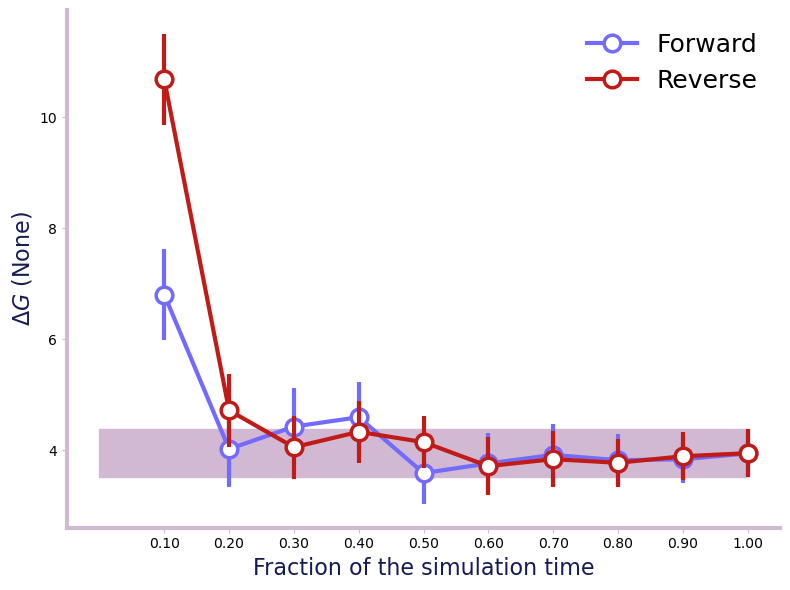

In [61]:
df = forward_backward_convergence(u_nk_list, 'mbar', verbose=False)
ax = plot_convergence(df)
ax.figure.savefig('dF_t.pdf')